In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import pandas as pd
import numpy as np
import torchvision
import cv2
import pytorch_lightning as pl
import torchmetrics as tm

from torch.utils.data import Dataset
from ZeroShotDataset import ZeroShotDataset
from params import *
# from DatasetModeling import *
from transformers import CLIPProcessor, CLIPModel
from LossFunc import *
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torch.utils.data import random_split
from CLIPConditionedSegFormerModel import CLIPConditionedSegFormer

In [2]:
torch.cuda.empty_cache()

In [ ]:
train_df = pd.read_csv(TrainParams.TRAIN_CSV_PATH)
clip_processor = CLIPProcessor.from_pretrained('openai/clip-vit-base-patch16')

In [ ]:
import pandas as pd

def balance_dataset(train_df):
    label_freqs = train_df["label"].value_counts()
    min_freq = label_freqs.min()
    max_freq = label_freqs.max()
    print(min_freq, max_freq)
    balanced_train_df = pd.DataFrame(columns=train_df.columns)
    for label in train_df["label"].unique():
        freq = int(max_freq * 10 * (min_freq / max_freq))
        freq = min(freq, label_freqs[label])
        freq = max(freq, min_freq)
        print(freq,label_freqs[label])
        balanced_train_df = balanced_train_df.append(train_df[train_df["label"] == label].sample(freq), ignore_index=True)
    return balanced_train_df

def inductive_dataset(train_df, unseen_labels):
    # Quita cualquier imagen y mascaras que contenga unseen_labels
    inductive_train_df = pd.DataFrame(columns=train_df.columns)
    for image_id, group in train_df.groupby('image'):
        if not group['label'].isin(unseen_labels).any():
            inductive_train_df = inductive_train_df.append(group)
    return inductive_train_df

def transductive_dataset(train_df, seen_labels):
    # Quita cualquier mascara que contenga unseen_labels
    transductive_train_df = pd.DataFrame(columns=train_df.columns)
    for label in seen_labels:
        transductive_train_df = transductive_train_df.append(train_df[train_df['label'] == label])
    return transductive_train_df

In [ ]:
balanced_train_df = balance_dataset(train_df)
inductive_dataset = inductive_dataset(train_df, TrainParams.UNSEEN_CLASSES)
transductive_dataset = transductive_dataset(train_df, TrainParams.SEEN_CLASSES)

121 64115


In [ ]:
balanced_train_df = balance_dataset(train_df)
x = balanced_train_df["label"].value_counts()
print(x.min(), x.max())

121 64115
1210 1222
1210 8501
1210 9189
1210 64115
1210 3529
1210 11837
1210 3252
1210 12250
1210 4385
1210 3502
1210 6841
1210 3952
1210 3353
1210 4678
1210 7111
1210 2360
1210 4659
1210 2877
1210 4326
1210 1699
1210 3025
1210 5528
1210 4452
1210 4423
1210 2402
1210 4139
1210 3588
1210 12774
1210 1547
1210 2533
1210 6126
705 705
1210 5570
1210 5332
1210 3593
1210 3968
1210 4114
1210 2184
1210 4262
1210 1586
1210 3237
1210 4803
1210 1711
1210 1733
1210 3524
1210 3486
1007 1007
1210 3682
217 217
947 947
1210 2140
1210 2365
1210 3555
1210 4561
1210 3810
1210 2243
1210 1683
1210 2925
1210 1939
1210 1876
1210 2115
1210 2941
1210 3076
1210 2506
1210 1968
1210 1523
1210 1529
189 189
1210 3166
1210 3394
1210 3476
1210 1916
1210 2986
1210 2261
1210 2143
1210 3082
1210 1654
1210 2546
1210 2629
960 960
1210 6672
1210 11137
1210 16282
1210 9886
1210 22575
1210 6252
1210 36465
1210 5053
1210 3259
1210 9522
1210 31481
1210 27657
1210 2313
1210 6598
1210 31808
1210 8893
1210 6618
1210 22525
1210 113

(array([  1.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          1.,   0.,   0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        156.]),
 array([ 121.  ,  131.89,  142.78,  153.67,  164.56,  175.45,  186.34,
         197.23,  208.12,  219.01,  229.9 ,  240.79,  251.68,  262.57,
         273.46,  284.35,  295.24,  306.13,  317.02,  327.91,  338.8 ,
         349.69,  360.58,  371.47,  382.36,  393.25,  404.14,  415.03,
         425.92,  436.81,  447.7 ,

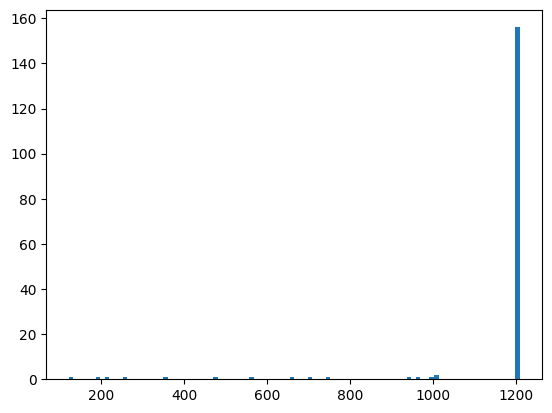

In [ ]:
# print val histogram
import matplotlib.pyplot as plt

plt.hist(balanced_train_df["label"].value_counts(), bins=100)

In [ ]:
# check if inductive has unseen classes
print("Inductive dataset has unseen classes: ", inductive_dataset['label'].isin(TrainParams.UNSEEN_CLASSES).any())

# check if transductive has unseen classes
print("Transductive dataset has unseen classes: ", transductive_dataset['label'].isin(TrainParams.UNSEEN_CLASSES).any())

# check if both datasets are the same
print("Inductive dataset and transductive dataset are the same: ", inductive_dataset.equals(transductive_dataset))

# check which daaset is bigger
print("Inductive dataset is bigger than transductive dataset: ", len(inductive_dataset) > len(transductive_dataset))

# print the size of each dataset
print("Original dataset size: ", len(train_df))
print("Inductive dataset size: ", len(inductive_dataset))
print("Transductive dataset size: ", len(transductive_dataset))

Inductive dataset has unseen classes:  False
Transductive dataset has unseen classes:  False
Inductive dataset and transductive dataset are the same:  False
Inductive dataset is bigger than transductive dataset:  False
Original dataset size:  973178
Inductive dataset size:  410559
Transductive dataset size:  805494


In [14]:
BOTH_CLASSES = ['unlabeled', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'street sign', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'hat', 'backpack', 'umbrella', 'shoe', 'eye glasses', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'plate', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'mirror', 'dining table', 'window', 'desk', 'toilet', 'door', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'blender', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush', 'hair brush', 'banner', 'blanket', 'branch', 'bridge', 'building-other', 'bush', 'cabinet', 'cage', 'cardboard', 'carpet', 'ceiling-other', 'ceiling-tile', 'cloth', 'clothes', 'clouds', 'counter', 'cupboard', 'curtain', 'desk-stuff', 'dirt', 'door-stuff', 'fence', 'floor-marble', 'floor-other', 'floor-stone', 'floor-tile', 'floor-wood', 'flower', 'fog', 'food-other', 'fruit', 'furniture-other', 'grass', 'gravel', 'ground-other', 'hill', 'house', 'leaves', 'light', 'mat', 'metal', 'mirror-stuff', 'moss', 'mountain', 'mud', 'napkin', 'net', 'paper', 'pavement', 'pillow', 'plant-other', 'plastic', 'platform', 'playingfield', 'railing', 'railroad', 'river', 'road', 'rock', 'roof', 'rug', 'salad', 'sand', 'sea', 'shelf', 'sky-other', 'skyscraper', 'snow', 'solid-other', 'stairs', 'stone', 'straw', 'structural-other', 'table', 'tent', 'textile-other', 'towel', 'tree', 'vegetable']
    
COCO_UNSEEN = [
    'cow', 'giraffe', 'suitcase', 'frisbee', 'skateboard',
    'carrot', 'scissors', 'cardboard', 'clouds', 'grass',
    'playingfield', 'river', 'road', 'tree', 'wall', 'concrete',
]

UNSEEN_CLASSES = []

for x in BOTH_CLASSES:
    if x in COCO_UNSEEN:
        UNSEEN_CLASSES.append(x)

SEEN_CLASSES = []

for x in BOTH_CLASSES:
    if x not in UNSEEN_CLASSES:
        SEEN_CLASSES.append(x)

# SEEN_CLASSES

print(len(SEEN_CLASSES), len(UNSEEN_CLASSES), len(BOTH_CLASSES), len(SEEN_CLASSES) + len(UNSEEN_CLASSES), len(SEEN_CLASSES) + len(UNSEEN_CLASSES) == len(BOTH_CLASSES))

# print class in unseen and seen but not in both
for x in UNSEEN_CLASSES:
    if x not in BOTH_CLASSES:
        print(x)

157 14 171 171 True


In [15]:
SEEN_CLASSES

['unlabeled',
 'person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'street sign',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'elephant',
 'bear',
 'zebra',
 'hat',
 'backpack',
 'umbrella',
 'shoe',
 'eye glasses',
 'handbag',
 'tie',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'surfboard',
 'tennis racket',
 'bottle',
 'plate',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 'mirror',
 'dining table',
 'window',
 'desk',
 'toilet',
 'door',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'blender',
 'book',
 'clock',
 'vase',
 'teddy bear',
 'hair drier',
 'toothbrush',
 'hair brush',
 'b

In [16]:
UNSEEN_CLASSES

['cow',
 'giraffe',
 'suitcase',
 'frisbee',
 'skateboard',
 'carrot',
 'scissors',
 'cardboard',
 'clouds',
 'grass',
 'playingfield',
 'river',
 'road',
 'tree']